In [1]:
import snntorch as snn
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import scipy.io
from pathlib import Path

from modules import SNN

### Load spiking data from from https://crcns.org/data-sets/vc/pvc-8

In [2]:
# load input spike data
mat = scipy.io.loadmat(Path('data') / '01.mat') # animal 01
spike_train_all = mat['resp_train'] # spike train of all neurons, neurons x image x trials x milliseconds
print(spike_train_all.shape)

(102, 956, 20, 106)


In [3]:
# get indices of all small natural images
idx_small_nat_images = torch.zeros(spike_train_all.shape[1])
idx_small_nat_images[:539:2] = 1

# get indices of all big natural images
idx_big_nat_images = torch.ones(spike_train_all.shape[1])
idx_big_nat_images[:539:2] = 0
idx_big_nat_images[540:] = 0

# get indices of all gratings
idx_gratings = torch.zeros(spike_train_all.shape[1])
idx_gratings[540:] = 1

In [4]:
# only keep well-centered channels
indcent = mat['INDCENT'].squeeze() # indicates if an stimulus was centered inside the neuron's RF and if the spikes were sorted
spike_train_cent = torch.tensor(spike_train_all[indcent == 1]) .float()
spike_train_cent.shape

torch.Size([26, 956, 20, 106])

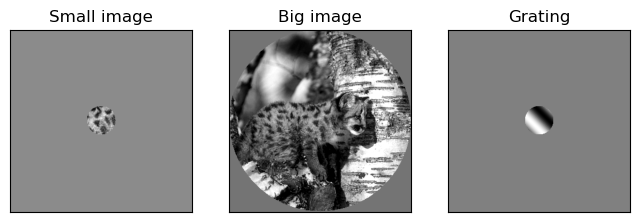

In [5]:
# plot some sample images for each category
images_all = mat['images'].squeeze()
fig, ax = plt.subplots(1, 3, figsize=(8, 8))

fig_titles = ['Small image', 'Big image', 'Grating']
fig_idx = [538, 539, 600]
for i in range(3):
    ax[i].imshow(images_all[fig_idx[i]], cmap='gray')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(fig_titles[i])

plt.show()

### Simulate network

In [6]:
# set up spike, use spikes of a selected big image, concatenate the trials
batch_size = 1
spk_in = spike_train_cent[:, 539, :, :].squeeze()
# spk_in = spk_in.reshape(spk_in.shape[0], -1)
# spk_in = spk_in.reshape(spk_in.shape[-1], batch_size, spk_in.shape[0]) # input shape must be n_times x n_batches x n_channels
print(spk_in.shape)

target = images_all[539]

torch.Size([26, 20, 106])


In [7]:
# layer parameters
n_inputs = spike_train_cent.shape[0] # train on all channels
n_pixels = images_all[0].shape[0] * images_all[0].shape[0]

n_hidden = 256
n_outputs = images_all[0].flatten().shape[0]
beta = 0.9 
n_iterations = 200

# set device (CPU or GPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device (CPU or GPU): ', device)

Device (CPU or GPU):  cpu


In [8]:
# initialize network 
network = SNN(n_inputs, n_hidden, n_outputs, beta, n_iterations, n_pixels)
network = network.to(device)
print(network)

SNN(
  (lgn): Conv2d(26, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lif1): Leaky()
  (v1_simple): Conv2d(16, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (v1_complex): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lif2): Leaky()
  (v2): Conv2d(4, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (v2_complex): AdaptiveMaxPool2d(output_size=1)
  (lif3): Leaky()
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=8, out_features=102400, bias=True)
  (lif4): Leaky()
)


In [9]:
# simulate and train network
n_epochs = 1

for epoch in range(n_epochs):
    data = spk_in.unsqueeze(0).to(device)
    targets = torch.tensor(target, device=device)

    # forward pass    
    network.train()
    spk4_rec, mem4_rec = network(data)

In [10]:
# decode image using rate code, i.e., each output neuron codes for a pixel
decoded_image = (spk4_rec.sum(dim=0).reshape(images_all[0].shape) / n_iterations).detach().numpy()  # firing rates normalized

### Plotting

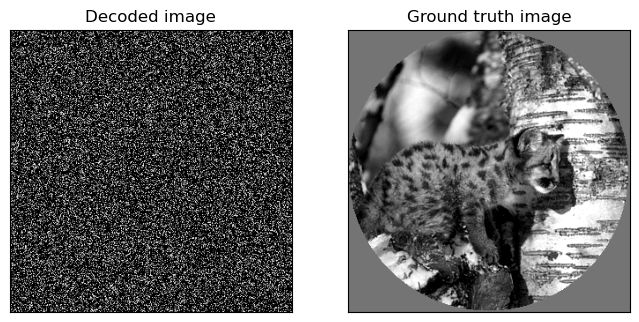

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))

ax[0].imshow(decoded_image, cmap='gray')
ax[0].set_title('Decoded image')

ax[1].imshow(images_all[539], cmap='gray')
ax[1].set_title('Ground truth image')

for i in range(2):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()

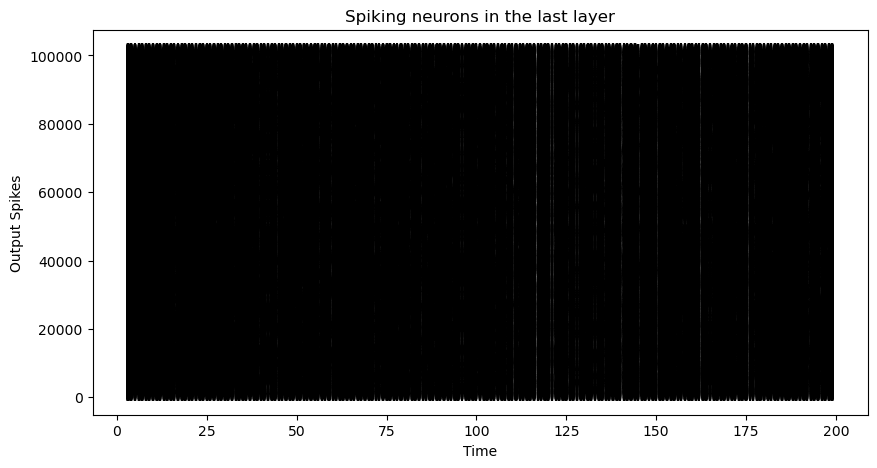

In [31]:
fig, ax = plt.subplots(figsize=(10, 5))
splt.raster(spk4_rec.squeeze(), ax, c="black", marker="|")
ax.set_ylabel("Output Spikes")
ax.set_xlabel('Time')  
ax.set_title('Spiking neurons in the last layer')
plt.show()

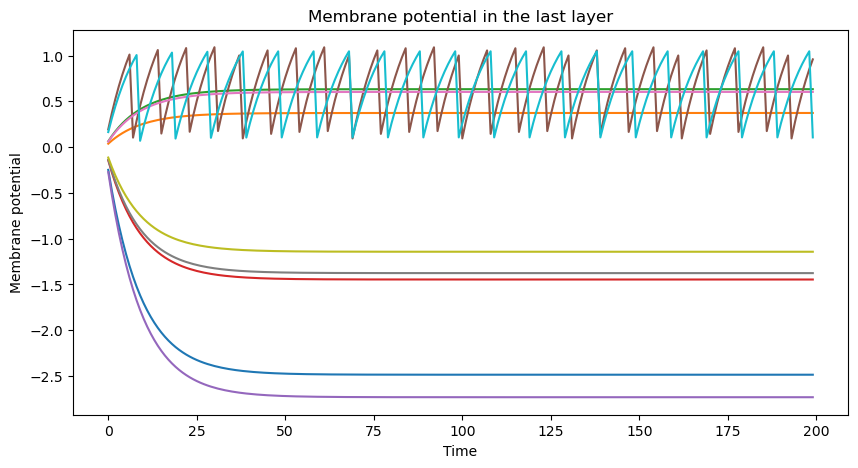

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(mem4_rec.detach().numpy().squeeze()[:, :10])
ax.set_ylabel("Membrane potential")
ax.set_xlabel('Time')  
ax.set_title('Membrane potential in the last layer')
plt.show()